In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle
import numpy as np
import sys
from PIL import Image
import io
# các thư viện gọi mô hình học sâu dự đoán chuỗi thời gian
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import model_from_json
from keras.preprocessing import sequence

# Các mô hình gọi và chỉnh sửa đồ thị
from scipy import interp
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.linear_model import LinearRegression
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

Using TensorFlow backend.


In [2]:
# nếu TRAINING_FLAG =0 -> đọc mô hình từ tệp, tính toán kết quả
# nếu TRAINING_FLAG =1-> học lại mô hình
TRAINING_FLAG = 0

# Mô hình LSTM chuỗi thời gian
# inputs: dữ liệu đầu vào
# output_size: kích thước đầu ra
# neurons: số lớp 
# activ_func: hàm kích hoạt 
# dropout: hàm loại bỏ các nơ-rơn dư thừa trong mạng
# loss: hàm mất mát
# optimizer: hàm tối ưu
def build_LSTM_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    #Khời tạo một chuỗi hàm
    model = Sequential()
    #gọi hàm LSTM
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    # xóa bỏ các nơ rơn dư thừa của mạng
    model.add(Dropout(dropout))
    # thêm lớp đầu ra và hàm kích hoạt tương ứng
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    # chạy hàm với các hàm mất mát và tối ưu
    model.compile(loss=loss, optimizer=optimizer)
    return model


In [3]:
# Đọc dữ liệu từ file
# Trong thư mục data có dữ liệu của 10 ngân hàng, các bạn đổi tên cột về như file csv mẫu để chạy
# Lưu ý:  Một tập dữ liệu chuỗi thơi gian khác nhau khi
# 1. Dữ liệu đầu vào khác nhau
# 2. Dữ liệu giống nhau, nhưng khác thời gian
myDf = pd.read_csv('data/vcb.csv')


print(myDf) 

         Date     Open     High      Low    Close   Volume
0    20181001  63.5000  63.5000  62.5000  62.5000  1932610
1    20180928  63.7000  64.0000  63.0000  63.0000  2104400
2    20180927  63.4000  64.2000  63.2000  63.4000  2121040
3    20180926  64.4000  64.9000  63.8000  63.8000  2099660
4    20180925  64.4000  65.2000  64.4000  64.4000  1031520
..        ...      ...      ...      ...      ...      ...
680  20160108  30.0626  30.2758  29.6362  29.9918   676340
681  20160107  30.4180  30.4890  29.8494  30.2050   935460
682  20160106  30.2048  30.7022  30.2048  30.5604   699490
683  20160105  30.4890  30.8444  30.1337  30.2050  1133260
684  20160104  30.7022  31.2708  30.2758  30.7025   761750

[685 rows x 6 columns]


In [4]:
# sắp xếp theo thứ tự thời gian, là bắt buộc khi làm bài toán chuỗi thời gian
myDf = myDf.sort_values(by='Date')

# chia dữ liệu thời gian làm 2 tập train, test
split_date = 20180515
training_set, test_set = myDf[myDf['Date']<split_date], myDf[myDf['Date']>=split_date]

# loại bỏ trường ngày tháng
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)
training_set=training_set.astype('float')

test_set=test_set.astype('float')

# quy đổi các thông tin về chứng khoán
# Close_off_high: Biên độ giao động
# Volatility Vận tốc gia tăng chứng khoán

kwargs = { 'Close_off_high': lambda x: 2*(x['High']- x['Close'])/(x['High']-x['Low'])-1,
        'Volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
training_set = training_set.assign(**kwargs)
test_set = test_set.assign(**kwargs)

# Loại bỏ dòng các trường không sử  dụng
training_set = training_set.drop('High', 1)
training_set = training_set.drop('Low', 1)
training_set = training_set.drop('Open', 1)

test_set = test_set.drop('High', 1)
test_set = test_set.drop('Low', 1)
test_set = test_set.drop('Open', 1)
test_set.to_csv("test_set.csv")

# chọn window_len, khung thời gian
# ở đây window_len bằng 10 quy định cứ lấy 10 ngày trước dự đáon 1 ngày sau
window_len = 10

norm_cols = ['Close','Volume']


In [5]:
# chuẩn hóa dữ liệu 

# chuyển dữ liệu về dạng vector 10 dòng 1
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
        #print(temp_set)
    LSTM_training_inputs.append(temp_set)

LSTM_training_outputs=LSTM_training_inputs

# chuẩn hóa dữ liệu [0,1]
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    # print(temp_set)
    LSTM_test_inputs.append(temp_set)
    LSTM_last_input=temp_set
    
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)
# lưu dữ liệu input cuối cùng làm đầu vào cho output
print(LSTM_last_input.shape)
LSTM_last_input.to_csv("lastdata.csv")
LSTM_last_input = LSTM_test_inputs[-1]
LSTM_last_input.shape = (1,10,4)
np.random.seed(202)
print(LSTM_training_inputs)
LSTM_training_Close_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
    

(10, 4)
[[[ 0.          0.          0.14231156  0.0324081 ]
  [-0.01620389  0.48770594  0.79935275  0.02331005]
  [-0.00462829 -0.08173285 -0.42983514  0.01646758]
  ...
  [-0.02083218 -0.41083032  0.99859287  0.01401802]
  [-0.03240778 -0.15801772  0.14193808  0.01674336]
  [-0.06018402  0.15543157  0.99939698  0.03349345]]

 [[ 0.          0.          0.79935275  0.02331005]
  [ 0.01176626 -0.382763   -0.42983514  0.01646758]
  [ 0.         -0.17454071 -0.11194497  0.02102702]
  ...
  [-0.01647078 -0.43403985  0.14193808  0.01674336]
  [-0.04470452 -0.2233468   0.99939698  0.03349345]
  [-0.09176295  0.42428039  0.39960602  0.05063282]]

 [[ 0.          0.         -0.42983514  0.01646758]
  [-0.01162943  0.33734578 -0.11194497  0.02102702]
  [-0.01860578 -0.03309554 -0.11194497  0.0212756 ]
  ...
  [-0.05581406  0.25827389  0.99939698  0.03349345]
  [-0.10232523  1.30750976  0.39960602  0.05063282]
  [-0.06279041  0.10271769 -0.88931447  0.04663362]]

 ...

 [[ 0.          0.        

In [6]:
# Gọi mô hình huấn luyện
if TRAINING_FLAG == 1:
    print("this is Close model")
    Close_model =build_LSTM_model(LSTM_training_inputs, output_size=1, neurons = 50)
    Close_model.fit(LSTM_training_inputs, LSTM_training_Close_outputs, 
                                epochs=20, batch_size=1, verbose=1, shuffle=True)

    # lưu mô hình vào file json
    model_json =  Close_model.to_json()
    model_output = "model/Close_model.json"
    weight_output = "model/Close_model.h5"
    with open(model_output, "w") as json_file:
            json_file.write(model_json)
            # serialize weights to HDF5
            Close_model.save_weights(weight_output)

   
model_output = 'model/Close_model.json'
weight_output = 'model/Close_model.h5'





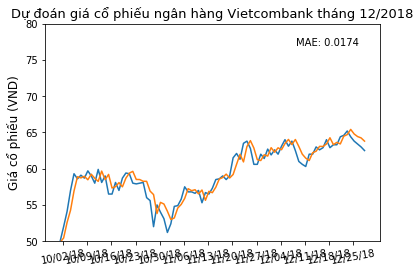

_____________________Result____________________________
Accuracy of LSTM: 0.9325842696629213


In [7]:
# đọc mô hình từ file json
json_file = open(model_output, 'r')
loaded_model_json = json_file.read()
json_file.close()
Close_model = model_from_json(loaded_model_json)
Close_model.load_weights(weight_output)

# tùy chỉnh tham số ngày tháng
rule = rrulewrapper(YEARLY, byweekday=1, interval=5)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')
date1 = datetime.date(2018, 10, 2)
date2 = datetime.date(2018, 12, 30)
delta = datetime.timedelta(days=1)

dates = drange(date1, date2, delta)

# in ra dữ liệu dữ đoán trên tập test
predict = Close_model.predict(LSTM_test_inputs)

# vẽ đồ thị mô tả
fig, ax1 = plt.subplots(1,1)
ax1.plot(dates,
         test_set['Close'][window_len:], label='Actual')
ax1.plot(dates,
         ((np.transpose(predict)+1) * test_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(predict)+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Dự đoán giá cổ phiếu ngân hàng Vietcombank tháng 12/2018',fontsize=13)
ax1.set_ylabel('Giá cổ phiếu (VND)',fontsize=12)
ax1.xaxis.set_major_locator(loc)
ax1.xaxis.set_major_formatter(formatter)
ax1.xaxis.set_tick_params(rotation=10, labelsize=10)
ax1.set_ylim(bottom=50)
ax1.set_ylim(top=80)
plt.show()

pre = ((np.transpose(predict)+1) * test_set['Close'].values[:-window_len])[0]
act = test_set['Close'][window_len:]

# tính toán sai số xu thế của mô hình
count = 0
for i in range(0,len(act)):
	try:
		if float(act[i+1]-act[i])/float(pre[i+1]-pre[i]):
			count = count +1
	except:
		continue
print("_____________________Result____________________________")
print("Accuracy of LSTM: "+str(float(count)/len(act)))